In [2]:
# palantir pseudotime analysis

# introduction

# import libraries

import palantir
import scanpy as sc
import pandas as pd
import os

# Plotting
import matplotlib
import matplotlib.pyplot as plt

# warnings
import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.filterwarnings(action="ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings(
    action="ignore", module="scanpy", message="No data for colormapping"
)

# Inline plotting
%matplotlib inline

In [3]:
# Load data- this is scanpy Anndata
data_dir = os.path.expanduser("./")
download_url = "https://dp-lab-data-public.s3.amazonaws.com/palantir/marrow_sample_scseq_counts.h5ad"
file_path = os.path.join(data_dir, "marrow_sample_scseq_counts.h5ad")
ad = sc.read(file_path, backup_url=download_url)
ad


100%|██████████| 69.9M/69.9M [00:07<00:00, 10.3MB/s]
/Users/bmoore/Desktop/scRNAseq/.venv/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 4142 × 16106

In [4]:
# Preprocess data

# normalize
sc.pp.normalize_per_cell(ad)
# log transform
palantir.preprocess.log_transform(ad)
# identify highly variable genes
sc.pp.highly_variable_genes(ad, n_top_genes=1500, flavor="cell_ranger")
# PCA
sc.pp.pca(ad)
ad

AnnData object with n_obs × n_vars = 4142 × 16106
    obs: 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [5]:
# Diffusion maps
# Palantir next determines the diffusion maps of the data as an estimate of the low dimensional phenotypic manifold of the data.

# Run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(ad, n_components=5)
# low dim embedding of the data is estimated based on the eigen gap
ms_data = palantir.utils.determine_multiscale_space(ad)

/Users/bmoore/Desktop/scRNAseq/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


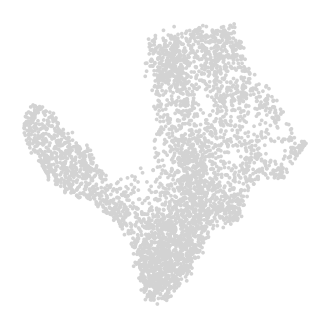

In [6]:
# Visualization
# force directed layout visualization recommended
# scanpy can be used to compute force directed layouts. We recommened the use of the diffusion kernel (see below) for computing force directed layouts 
# Force Atlas package should be installed for this analysis and can be installed using conda install -c conda-forge fa2. Note that fa2 is not supported by python3.9

sc.pp.neighbors(ad)
sc.tl.umap(ad)
# Use scanpy functions to visualize umaps or FDL
sc.pl.embedding(
    ad,
    basis="umap",
    frameon=False,
)


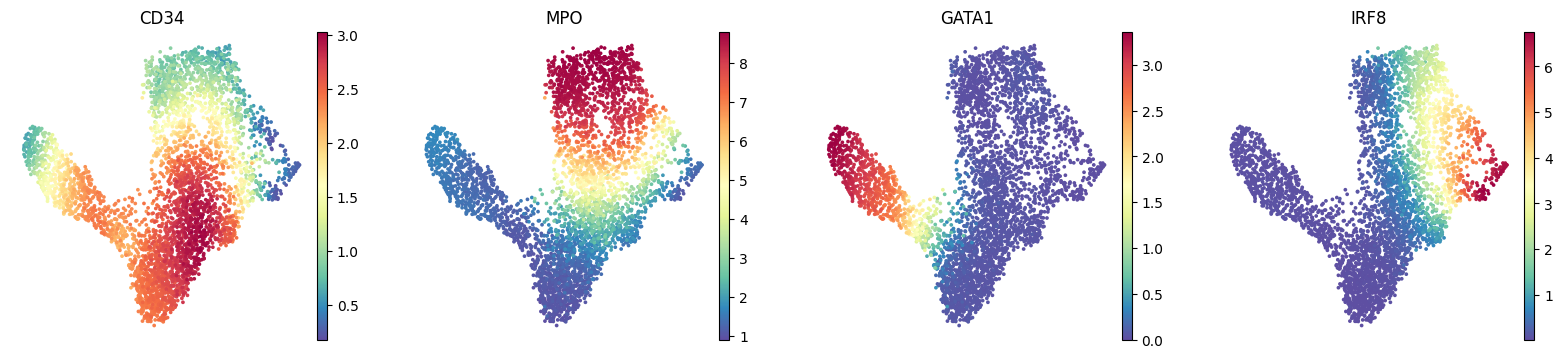

In [7]:
# MAGIC imputation
# Palantir uses MAGIC to impute the data for visualization and determining gene expression trends.
imputed_X = palantir.utils.run_magic_imputation(ad)
# gene expression visualization on UMAP
sc.pl.embedding(
    ad,
    basis="umap",
    layer="MAGIC_imputed_data",
    color=["CD34", "MPO", "GATA1", "IRF8"],
    frameon=False,
)
plt.show()

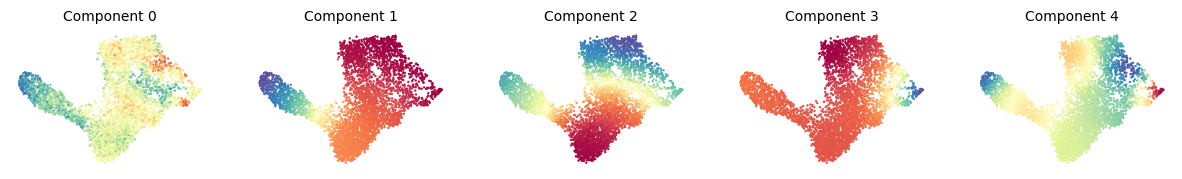

In [8]:
# Diffusion maps visualization
palantir.plot.plot_diffusion_components(ad)
plt.show()

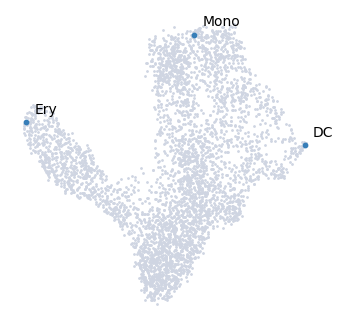

Sampling and flocking waypoints...
Time for determining waypoints: 0.0009758353233337402 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.0966281811396281 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [9]:
# Running Palantir

# An approximate early cell can be specified, or Palantir can automatically determine the terminal states.
# Here are known terminal states for this data
terminal_states = pd.Series(
    ["DC", "Mono", "Ery"],
    index=["Run5_131097901611291", "Run5_134936662236454", "Run4_200562869397916"],
)
palantir.plot.highlight_cells_on_umap(ad, terminal_states)
plt.show()

# Run Palantir
start_cell = "Run5_164698952452459"
pr_res = palantir.core.run_palantir(
    ad, start_cell, num_waypoints=500, terminal_states=terminal_states
)

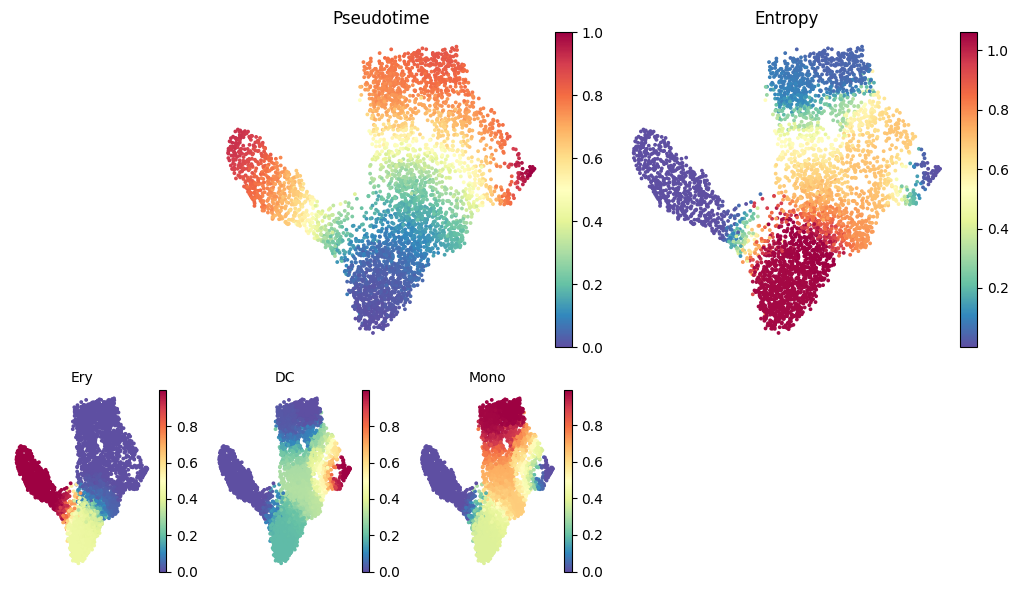

In [10]:
# Palantir Results
# 1. Pseudotime: Pseudo time ordering of each cell
# 2. Terminal state probabilities: Matrix of cells X terminal states. Each entry represents the probability of the corresponding cell reaching the respective terminal state
# 3. Entropy: A quantiative measure of the differentiation potential of each cell computed as the entropy of the multinomial terminal state probabilities
palantir.plot.plot_palantir_results(ad, s=3)
plt.show()

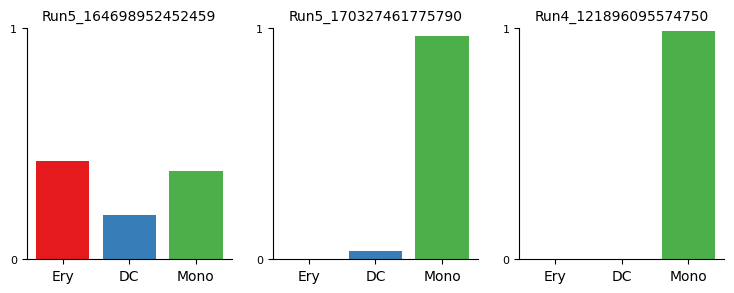

In [11]:
# Terminal state probability distributions of individual cells can be visualized using the plot_terminal_state_probs function
cells = [
    "Run5_164698952452459",
    "Run5_170327461775790",
    "Run4_121896095574750",
]
palantir.plot.plot_terminal_state_probs(ad, cells)
plt.show()

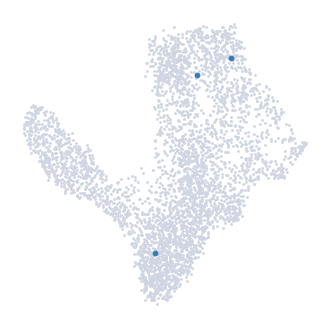

In [12]:
palantir.plot.highlight_cells_on_umap(ad, cells)
plt.show()

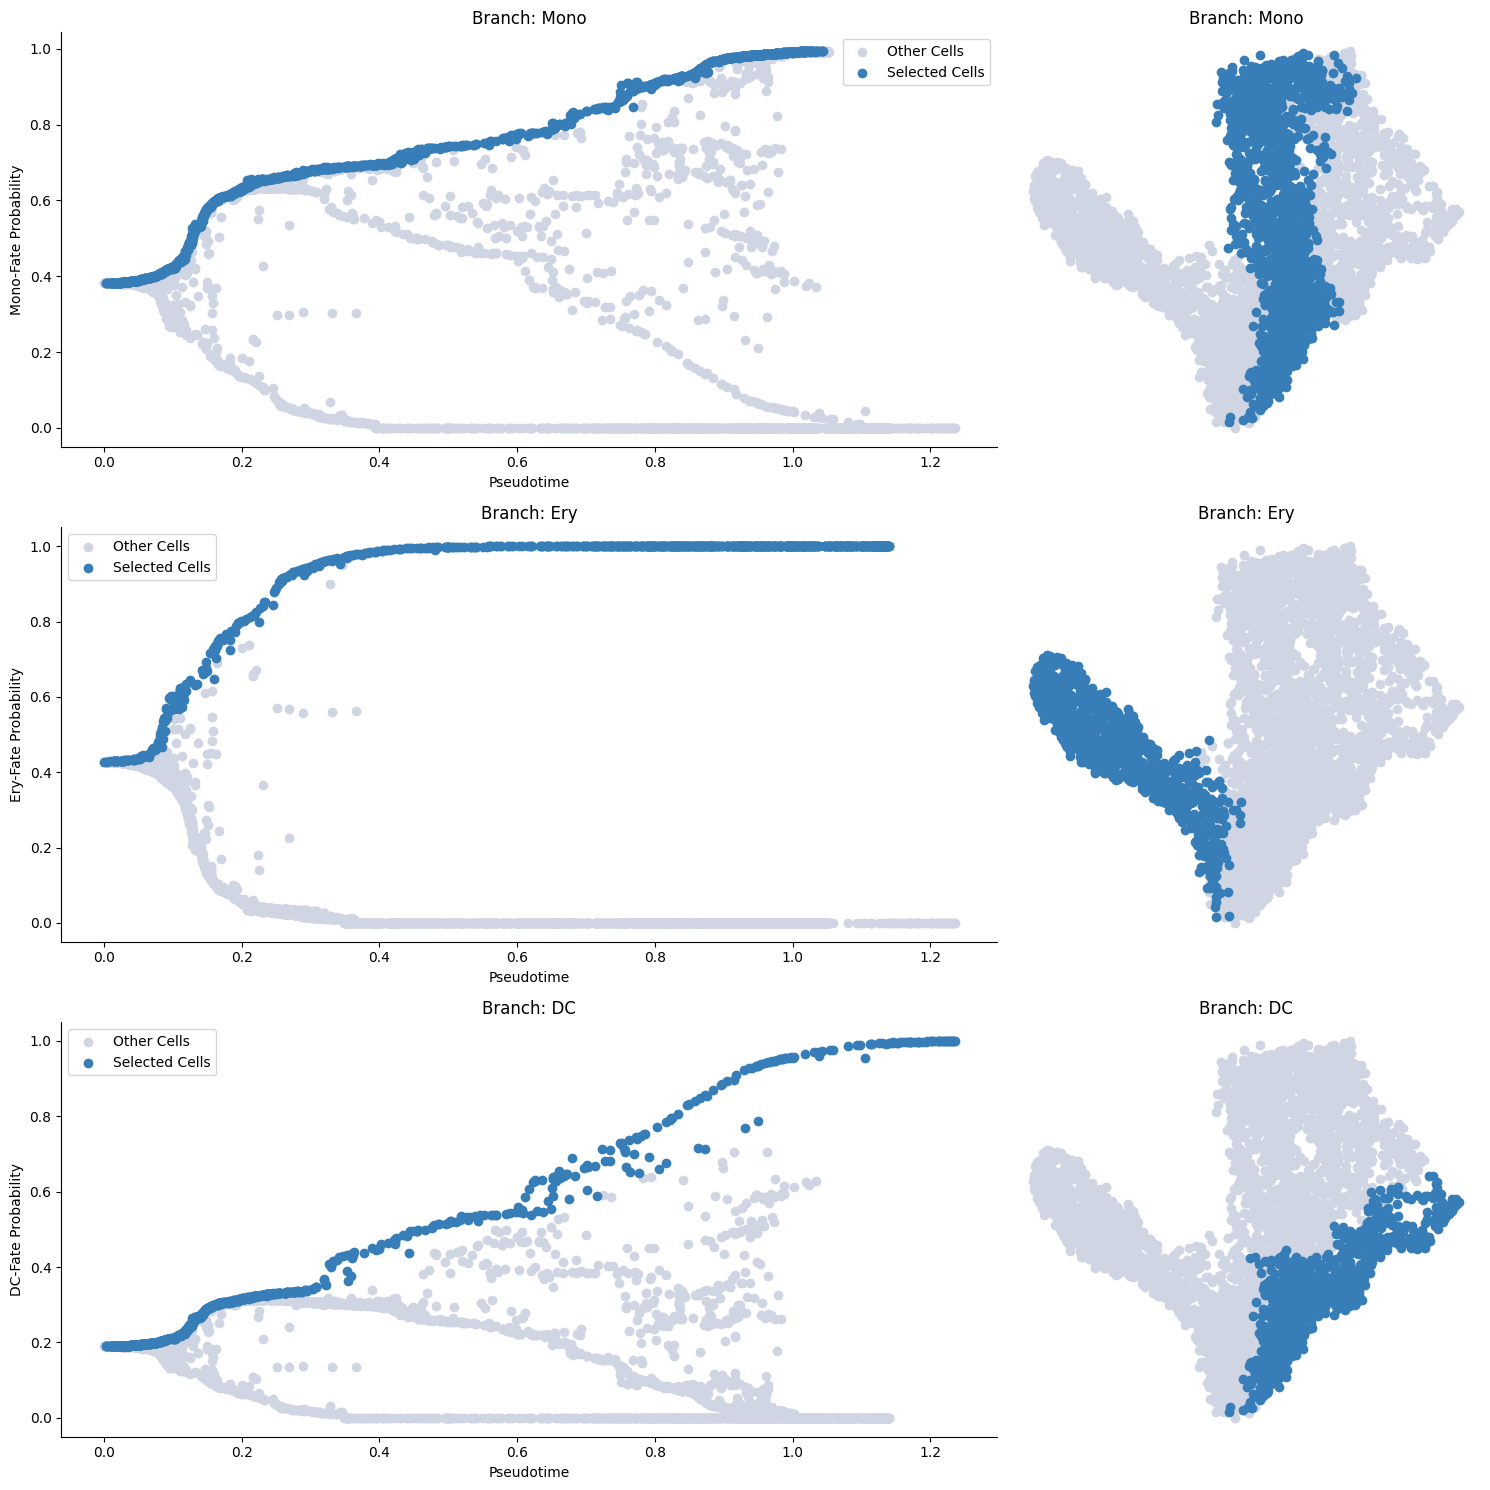

In [14]:
# Gene expression trends

# Select cells
# Before computing the gene expression trends, we first need to select cells associated with a specific branch of the pseudotime trajectory.
masks = palantir.presults.select_branch_cells(ad, eps=0)
# visualize the branck selection
palantir.plot.plot_branch_selection(ad)
plt.show()

Ery
[2023-10-12 14:28:34,507] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (889) and rank = 1.0.
[2023-10-12 14:28:34,508] [INFO    ] Using covariance function Matern52(ls=1.0).
DC
[2023-10-12 14:28:36,019] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (880) and rank = 1.0.
[2023-10-12 14:28:36,019] [INFO    ] Using covariance function Matern52(ls=1.0).
Mono
[2023-10-12 14:28:36,907] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (1,590) and rank = 1.0.
[2023-10-12 14:28:36,909] [INFO    ] Using covariance function Matern52(ls=1.0).


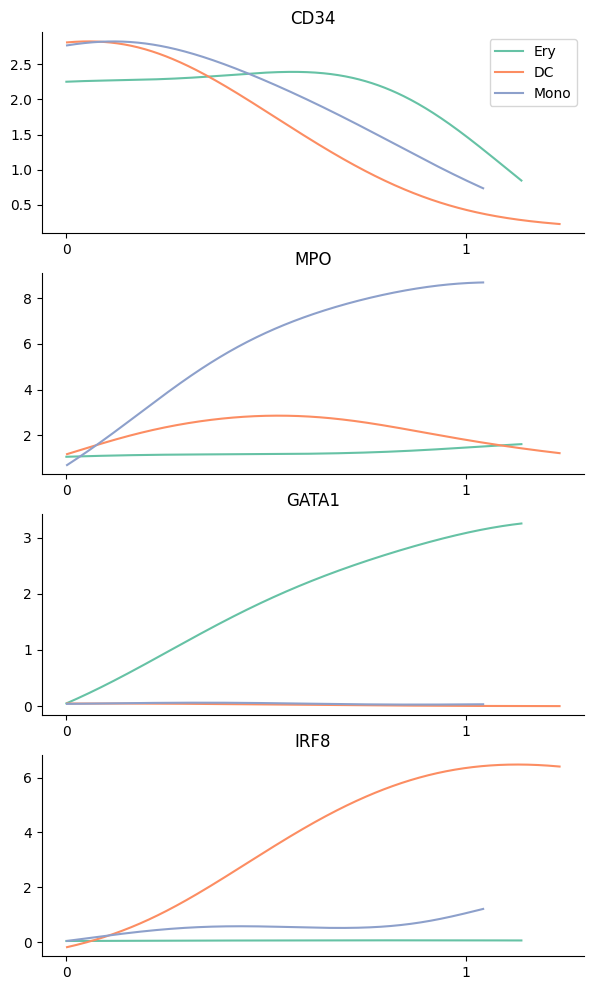

In [15]:
# Determine marker gene trends using the  Mellon Function Estimator
gene_trends = palantir.presults.compute_gene_trends(
    ad,
    expression_key="MAGIC_imputed_data",
)
# visualize trends
genes = ["CD34", "MPO", "GATA1", "IRF8"]
palantir.plot.plot_gene_trends(ad, genes)
plt.show()

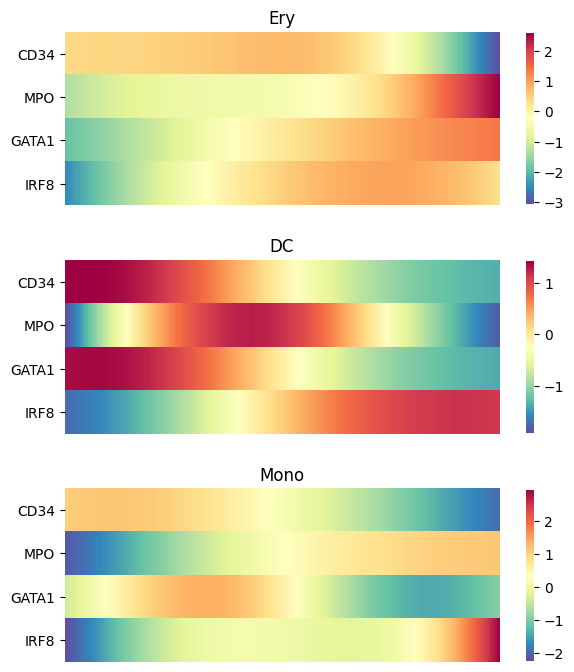

In [16]:
# Heatmap trend visualization
palantir.plot.plot_gene_trend_heatmaps(ad, genes)
plt.show()

/Users/bmoore/Desktop/scRNAseq/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


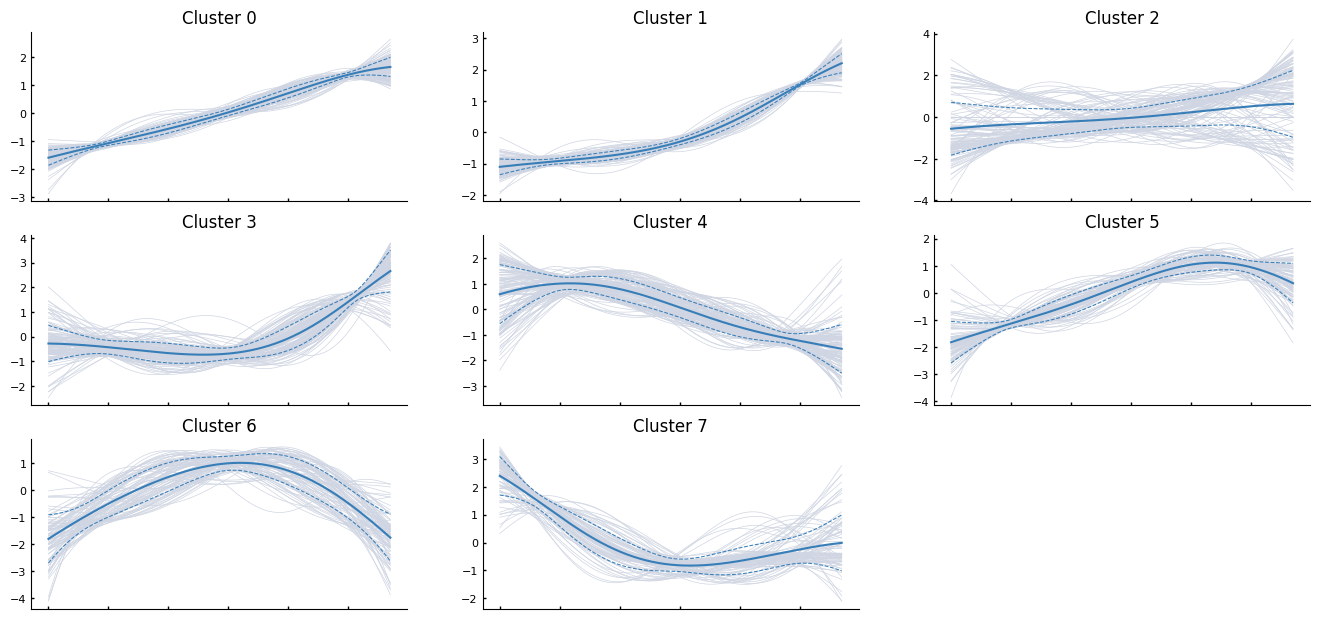

In [17]:
# Clustering
# Gene expression trends can be clustered and visualized
# Here the first 1000 genes along the erythroid genes are clustered
more_genes = ad.var_names[:1000]
communities = palantir.presults.cluster_gene_trends(ad, "Ery", more_genes)
palantir.plot.plot_gene_trend_clusters(ad, "Ery")
plt.show()

In [18]:
# Save results
file_path = os.path.join(data_dir, "marrow_sample_scseq_processed.h5ad")
ad.write(file_path)
# package versions
import pkg_resources

for package in pkg_resources.working_set:
    print(package.key, pkg_resources.get_distribution(package).version)

fsspec 2023.9.2
xarray 2023.9.0
certifi 2023.7.22
pytz 2023.3.post1
tzdata 2023.3
setuptools 65.5.0
pyzmq 25.1.1
pip 23.2.1
packaging 23.2
attrs 23.1.0
contextlib2 21.6.0
rich 13.6.0
websockets 11.0.3
pillow 10.0.1
ipython 8.16.1
natsort 8.4.0
jupyter-client 8.4.0
click 8.1.7
ipykernel 6.25.2
deepdiff 6.6.0
tornado 6.3.3
importlib-resources 6.1.0
multidict 6.0.4
pyyaml 6.0.1
traitlets 5.11.2
psutil 5.9.5
jupyter-core 5.4.0
decorator 5.1.1
tzlocal 5.1
tqdm 4.66.1
fonttools 4.43.1
protobuf 4.24.4
beautifulsoup4 4.12.2
typing-extensions 4.8.0
pexpect 4.8.0
gdown 4.7.1
progressbar2 4.2.0
ordered-set 4.1.0
readchar 4.0.5
async-timeout 4.0.3
cmake 3.27.6
zipp 3.17.0
filelock 3.12.4
platformdirs 3.11.0
h5py 3.10.0
aiohttp 3.8.6
python-utils 3.8.1
matplotlib 3.7.1
anyio 3.7.1
rpy2 3.5.14
idna 3.4
charset-normalizer 3.3.0
opt-einsum 3.3.0
threadpoolctl 3.2.0
inquirer 3.1.3
pyparsing 3.1.1
networkx 3.1
prompt-toolkit 3.0.39
loompy 3.0.7
cython 3.0.3
jinja2 3.0.3
markdown-it-py 3.0.0
requests 2.3